<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'> Chapter11</font></h3>

元のノートブックは以下です。  
https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb

In [1]:
import warnings 

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 42
np.random.seed(42)


In [2]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [3]:
d = pd.read_csv("chimpanzees.csv", sep=";")
# actorを0というインデックスに変換する
d.actor = d.actor -1
d

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1
...,...,...,...,...,...,...,...,...
499,6,4.0,1,6,64,1,1,1
500,6,6.0,1,6,66,1,1,1
501,6,3.0,1,6,68,0,0,1
502,6,7.0,1,6,70,0,0,1


In [4]:
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]

,actor,prosoc_left,condition,treatment
0,0,0,0,0
1,0,0,0,0
2,0,1,0,1
3,0,0,0,0
4,0,1,0,1
...,...,...,...,...
499,6,1,1,3
500,6,1,1,3
501,6,0,1,2
502,6,0,1,2


In [5]:
d.groupby("treatment").first()[["prosoc_left", "condition"]]

,prosoc_left,condition
treatment,,
0,0,0
1,1,0
2,0,1
3,1,1


In [6]:
with pm.Model() as m11_1:
    a = pm.Normal("a", 0.0, 10.0)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_1 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1 = prior_11_1["prior"]


with pm.Model() as m11_1bis:
    a = pm.Normal("a", 0.0, 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_1bis = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1bis = prior_11_1bis["prior"]

Sampling: [a, pulled_left]
Sampling: [a, pulled_left]


<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:事前分布の確認</font></h3>

* 切片パラメータの事前分布の妥当性を比較する。
* idata_11_1bisの方は分散が小さい。
* それぞれの設定でサンプリングし事前予測分布を生成する。
* pm.math.invlogit(a)としているのはアウトカムのスケールに合わせるため。  
  (リンク関数がlogitなので逆の操作をしている)  
  つまり、元のモデルは、  
  $ L_i \textasciitilde{} Binomial(1, p_i), $
  
  $ Logit(p_i) = \alpha, $
  
  $ \alpha \textasciitilde{} Normal(0, \omega) $


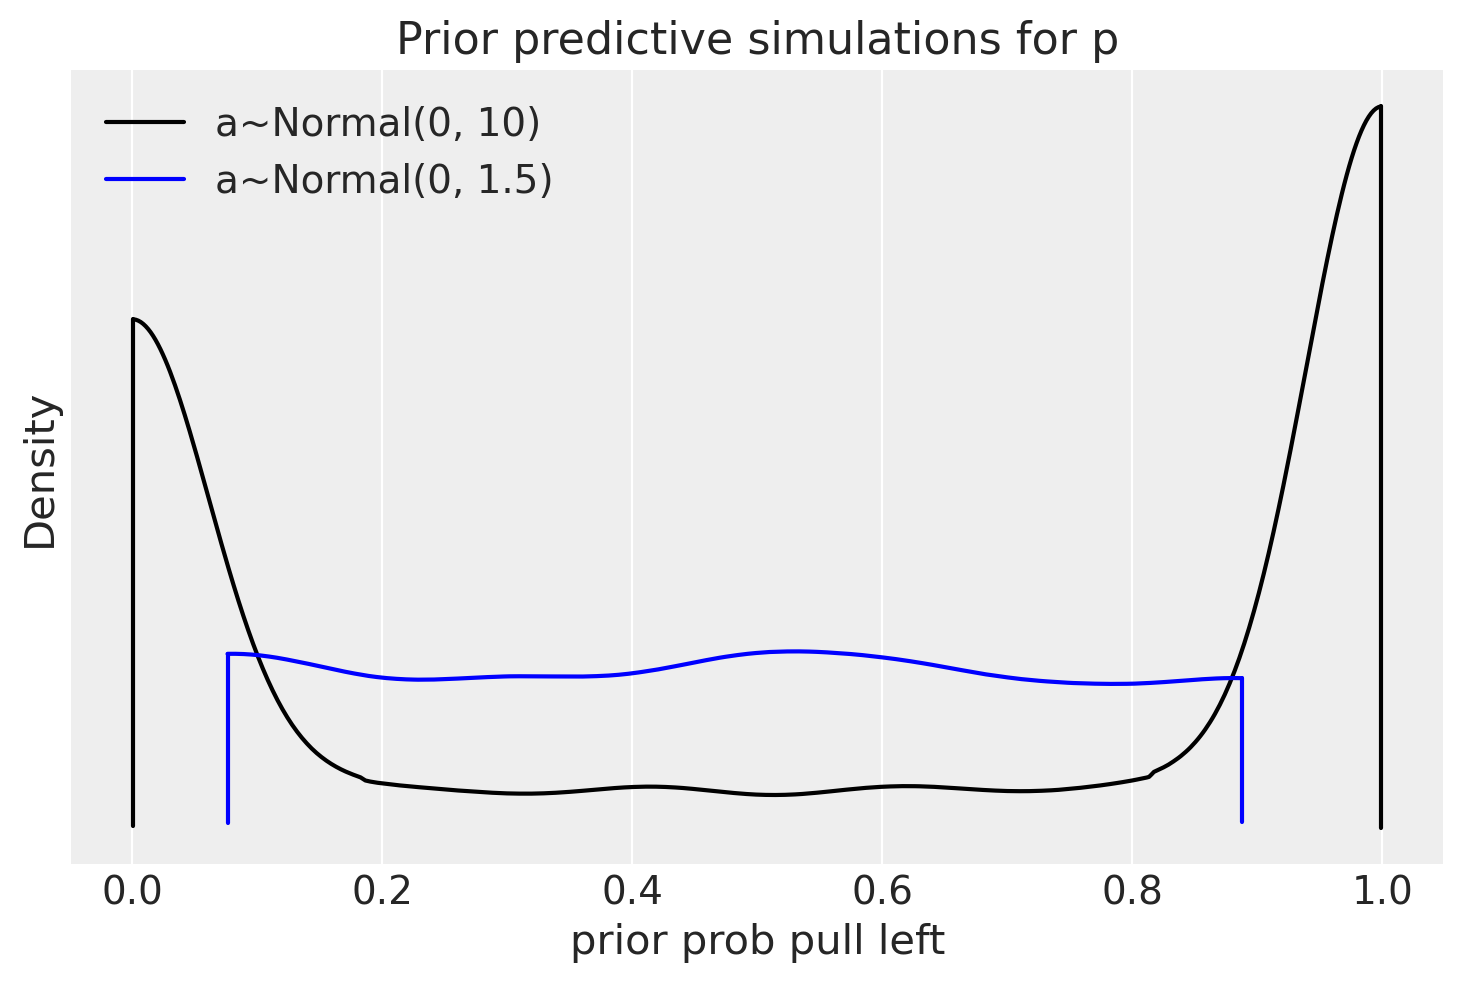

In [7]:
ax = az.plot_density(
    [idata_11_1, idata_11_1bis],
    data_labels=["a~Normal(0, 10)", "a~Normal(0, 1.5)"],
    group="prior",
    colors=["k", "b"],
    var_names=["p"],
    point_estimate=None,
)[0]
ax[0].set_xlabel("prior prob pull left")
ax[0].set_ylabel("Density")
ax[0].set_title("Prior predictive simulations for p");

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:事前分布の妥当性</font></h3>

* az.plot_density()は確率密度に関するリストリストを生成し、最初のAxesオブジェクトを取り出して、それをax変数に代入する。  
* つまり、axにはAxesオブジェクトが直接格納されている。

In [8]:
with pm.Model () as m11_2:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 10.0, shape=4)

    p = pm.math.invlogit(a + b[d.treatment.values])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_2 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
prior_2 = prior_11_2["prior"]

with pm.Model() as m11_3:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 0.5, shape=4)

    p = pm.math.invlogit(a + b[d.treatment.values])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_3 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
prior_3 = prior_11_3["prior"]

Sampling: [a, b, pulled_left]
Sampling: [a, b, pulled_left]


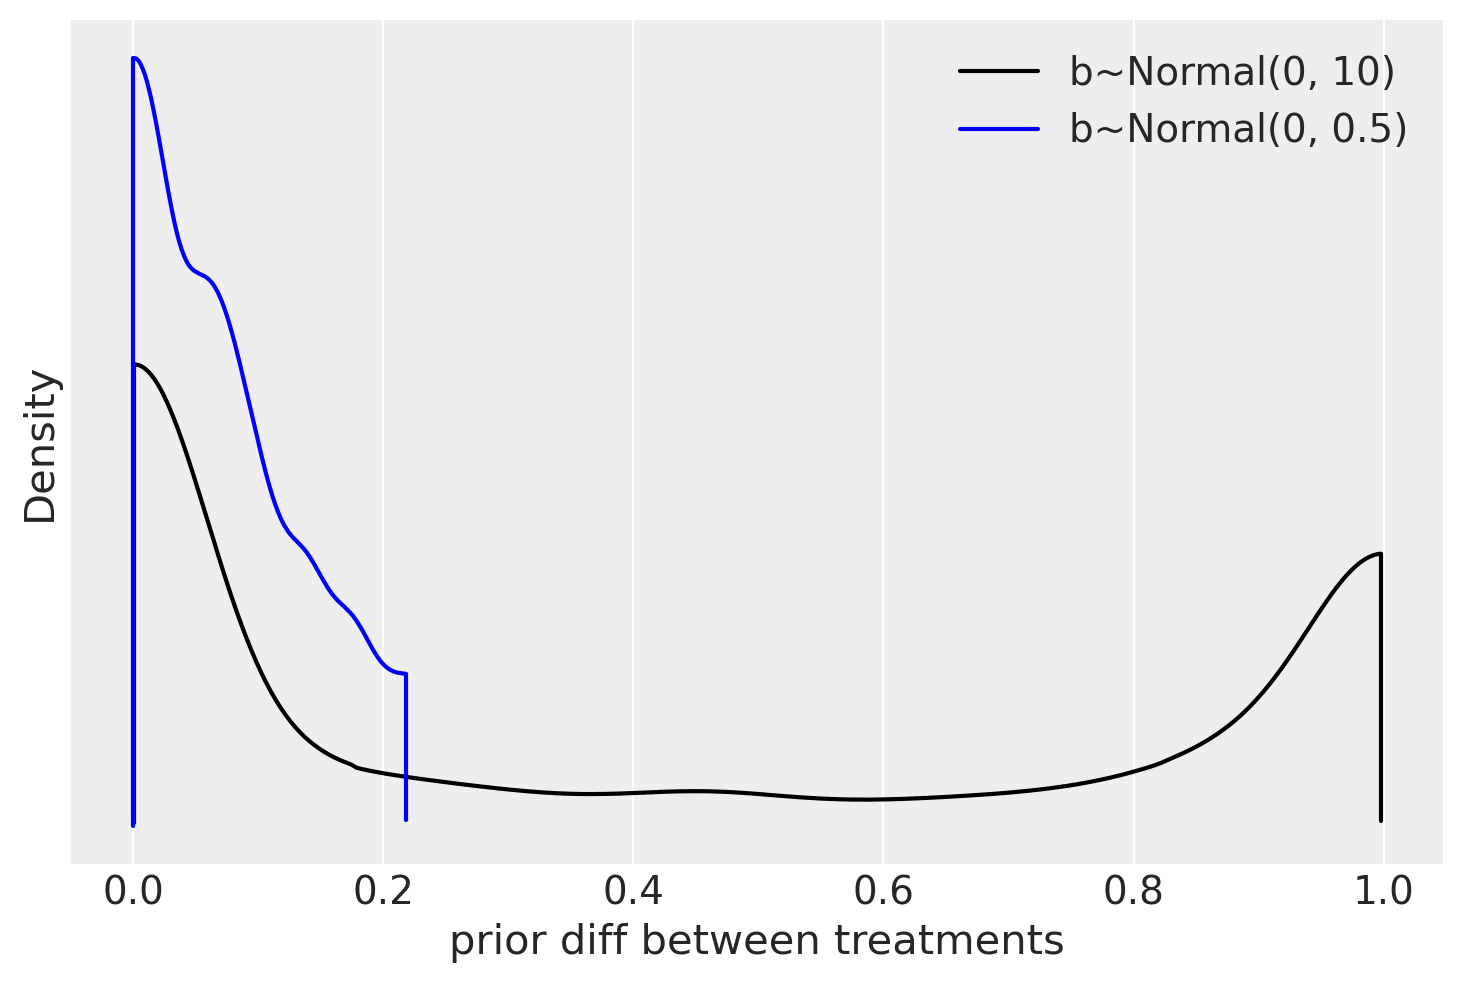

In [9]:
p_treat1, p_treat2 =(
    logistic(prior_2["a"] + prior_2["b"].sel(b_dim_0=0)),
    logistic(prior_2["a"] + prior_2["b"].sel(b_dim_0=1)),
)

p_treat1_bis, p_treat2_bis = (
    logistic(prior_3["a"] + prior_3["b"].sel(b_dim_0=0)),
    logistic(prior_3["a"] + prior_3["b"].sel(b_dim_0=1)),
)

ax = az.plot_density(
    [np.abs(p_treat1 - p_treat2).values, np.abs(p_treat1_bis - p_treat2_bis).values],
    data_labels=["b~Normal(0, 10)", "b~Normal(0, 0.5)"],
    group="prior",
    colors=["k", "b"],
    point_estimate=None,
)[0]
ax[0].set_xlabel("prior diff between treatments")
ax[0].set_ylabel("Density")
ax[0].set_title(None);

In [10]:
np.abs(p_treat1_bis - p_treat2_bis).mean().values

array(0.10003228)

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:係数の絶対事前差</font></h3>

* 上のコードで新しく、変数treatmentと、bというパラメータを追加したモデルをつくり、その事前分布の形を比較し検討した。
* treatmentがあるかないかについてpの「差」を計算し、それをbの事前分布の異なるモデル同士で比較する。
* おそらく差が無いことが多いだろうと考えられるので青色の事前分布を採用する。

In [11]:
actor_idx, actors = pd.factorize(d.actor)
treat_idx, treatments = pd.factorize(d.treatment)

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:カテゴリカルデータのインデックス化</font></h3>
    
* 個体の識別番号をインデックス化し、actor_idxにアンパック代入する。
* actorsには元のカテゴリカル値が入る。
* treatmentも同様。

In [12]:
with pm.Model() as m11_4:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    b = pm.Normal("b", 0.0, 0.5, shape=len(treatments))

    actor_id = pm.intX(pm.Data("actor_id", actor_idx))
    treat_id = pm.intX(pm.Data("treat_id", treat_idx))
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_id] + b[treat_id]))

    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_11_4 = pm.sample(random_seed=RANDOM_SEED)

az.summary(trace_11_4, var_names=["a", "b"], round_to=2)

C:\Users\satyk\anaconda3\envs\stat-rethink2-pymc_v4\lib\site-packages\pymc\data.py:676: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.43,0.33,-0.98,0.06,0.01,0.01,1721.45,2515.89,1.0
a[1],3.91,0.73,2.74,5.05,0.01,0.01,3664.29,3146.14,1.0
a[2],-0.74,0.34,-1.28,-0.18,0.01,0.01,2035.35,2914.88,1.0
a[3],-0.74,0.34,-1.28,-0.20,0.01,0.01,1957.35,2414.52,1.0
a[4],-0.44,0.33,-0.96,0.09,0.01,0.01,1583.85,2508.89,1.0
a[5],0.49,0.34,-0.08,1.01,0.01,0.01,1852.32,2515.39,1.0
a[6],1.97,0.42,1.26,2.61,0.01,0.01,2334.13,2983.31,1.0
b[0],-0.05,0.29,-0.50,0.40,0.01,0.00,1643.24,2524.32,1.0
b[1],0.47,0.29,0.01,0.92,0.01,0.01,1520.06,2539.85,1.0
b[2],-0.39,0.29,-0.84,0.06,0.01,0.01,1526.26,2564.46,1.0


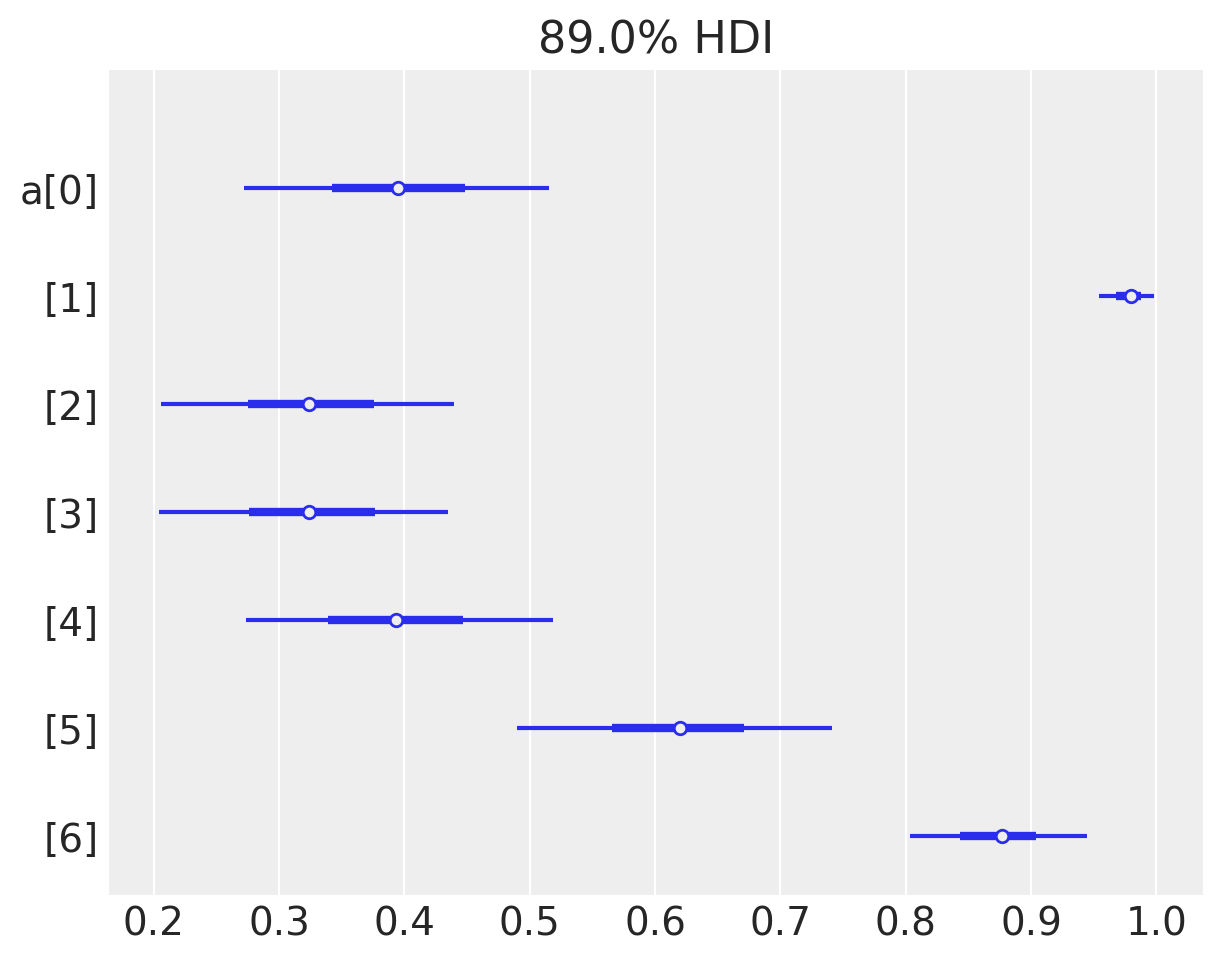

In [13]:
az.plot_forest(trace_11_4, var_names=["a"], transform=logistic, combined=True);

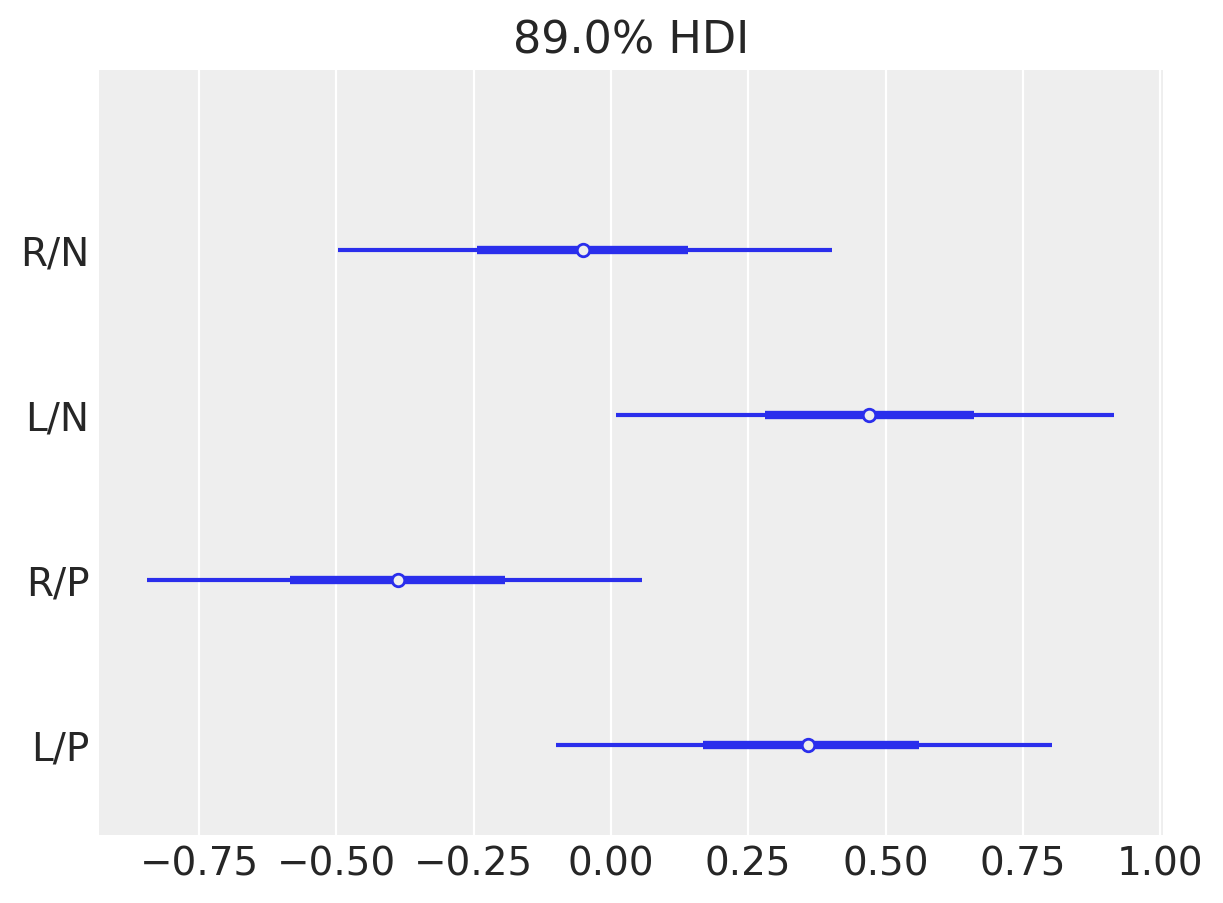

In [14]:
ax = az.plot_forest(trace_11_4, var_names=["b"], combined=True)
ax[0].set_yticklabels(["L/P", "R/P", "L/N", "R/N"]);

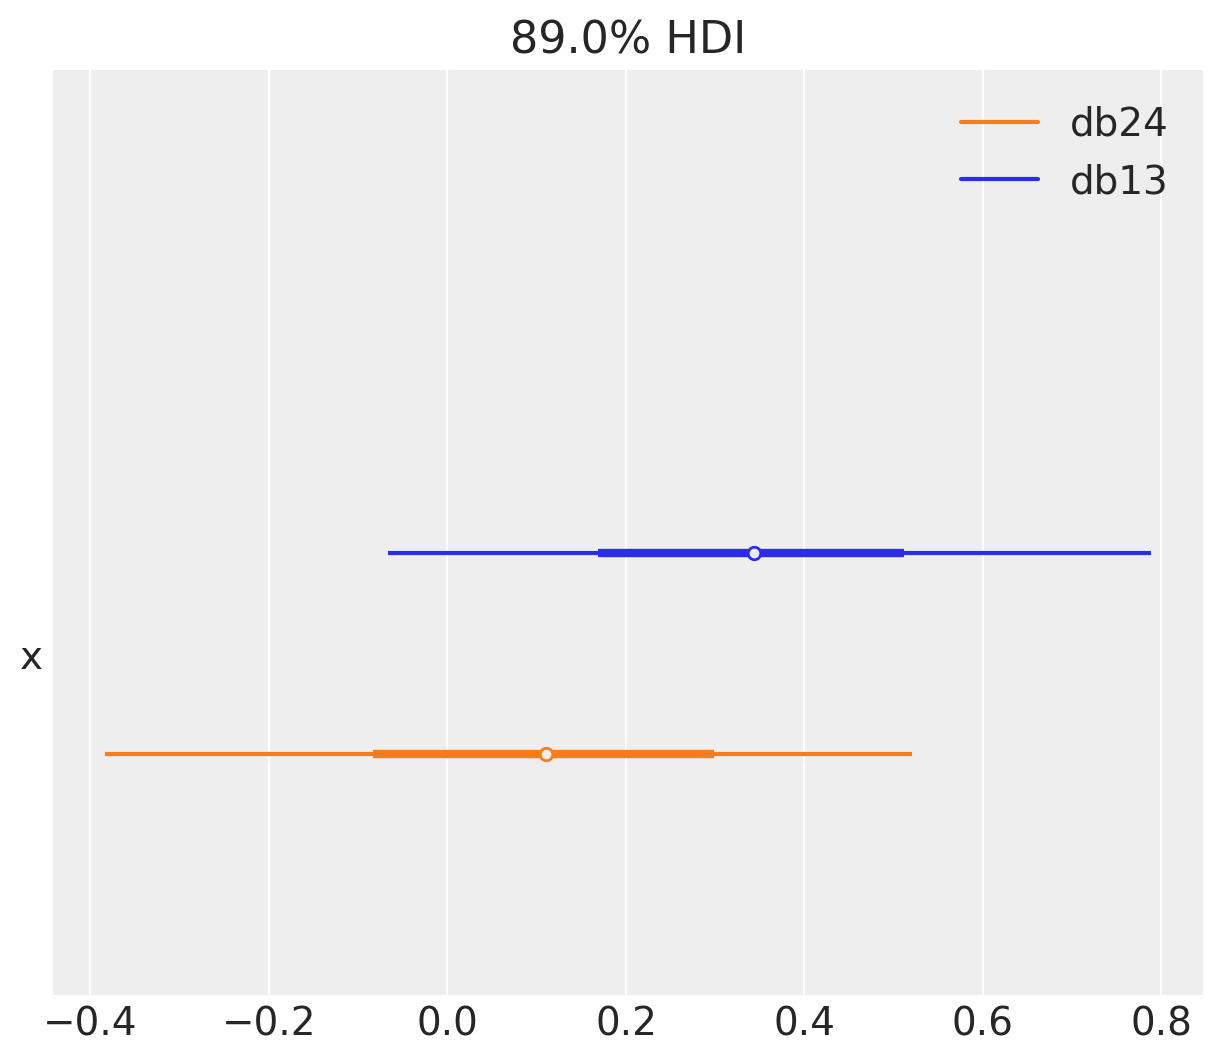

In [15]:
db13 = trace_11_4.posterior["b"].sel(b_dim_0=0) - trace_11_4.posterior["b"].sel(b_dim_0=2)
db24 = trace_11_4.posterior["b"].sel(b_dim_0=1) - trace_11_4.posterior["b"].sel(b_dim_0=3)
az.plot_forest([db13.values, db24.values], model_names=["db13", "db24"], combined=True);

In [16]:
pl = d.groupby(["actor", "treatment"]).agg("mean")["pulled_left"].unstack()
pl

treatment,0,1,2,3
actor,,,,
0,0.333333,0.500000,0.277778,0.555556
1,1.000000,1.000000,1.000000,1.000000
2,0.277778,0.611111,0.166667,0.333333
3,0.333333,0.500000,0.111111,0.444444
4,0.333333,0.555556,0.277778,0.500000
5,0.777778,0.611111,0.555556,0.611111
6,0.777778,0.833333,0.944444,1.000000


### Code 11.16 and 11.17

以下のコードはエラーが出る。
```
with m11_4:
    pm.set_data({"actor_id": np.repeat(range(7), 4), "treat_id": list(range(4)) * 7})
    ppd = pm.sample_posterior_predictive(trace_11_4, random_seed=RANDOM_SEED, var_names=["p"])[
        "posterior_predictive"
    ]["p"]
p_mu = np.array(ppd.mean(["chain", "draw"])).reshape((7, 4))

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Oct 19 2023

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

numpy     : 1.25.2
aesara    : 2.8.7
pymc      : 4.3.0
arviz     : 0.13.0
scipy     : 1.11.2
matplotlib: 3.7.1
pandas    : 2.1.0

Watermark: 2.4.3



使用しているパッケージのバージョンが引用元のnotebookと異なるようです。
上記のバージョンでも使えるように変更します。  
以下のようにモデルを書き直す。

In [18]:
with pm.Model() as m11_4:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    b = pm.Normal("b", 0.0, 0.5, shape=len(treatments))

    # Create shared variables using pm.MutableData()
    actor_id = pm.Data("actor_id", actor_idx, mutable=True)
    treat_id = pm.Data("treat_id", treat_idx, mutable=True)

    p = pm.Deterministic("p", pm.math.invlogit(a[actor_id] + b[treat_id]))

    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)
    trace_11_4 = pm.sample(random_seed=RANDOM_SEED)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [19]:
with m11_4:
    pm.set_data({"actor_id": np.repeat(range(7), 4), "treat_id": list(range(4)) * 7})
    ppd = pm.sample_posterior_predictive(trace_11_4, random_seed=RANDOM_SEED, var_names=["p"])[
        "posterior_predictive"
    ]["p"]
p_mu = np.array(ppd.mean(["chain", "draw"])).reshape((7, 4))

Sampling: []


Text(0.5, 1.0, 'posterior predictions')

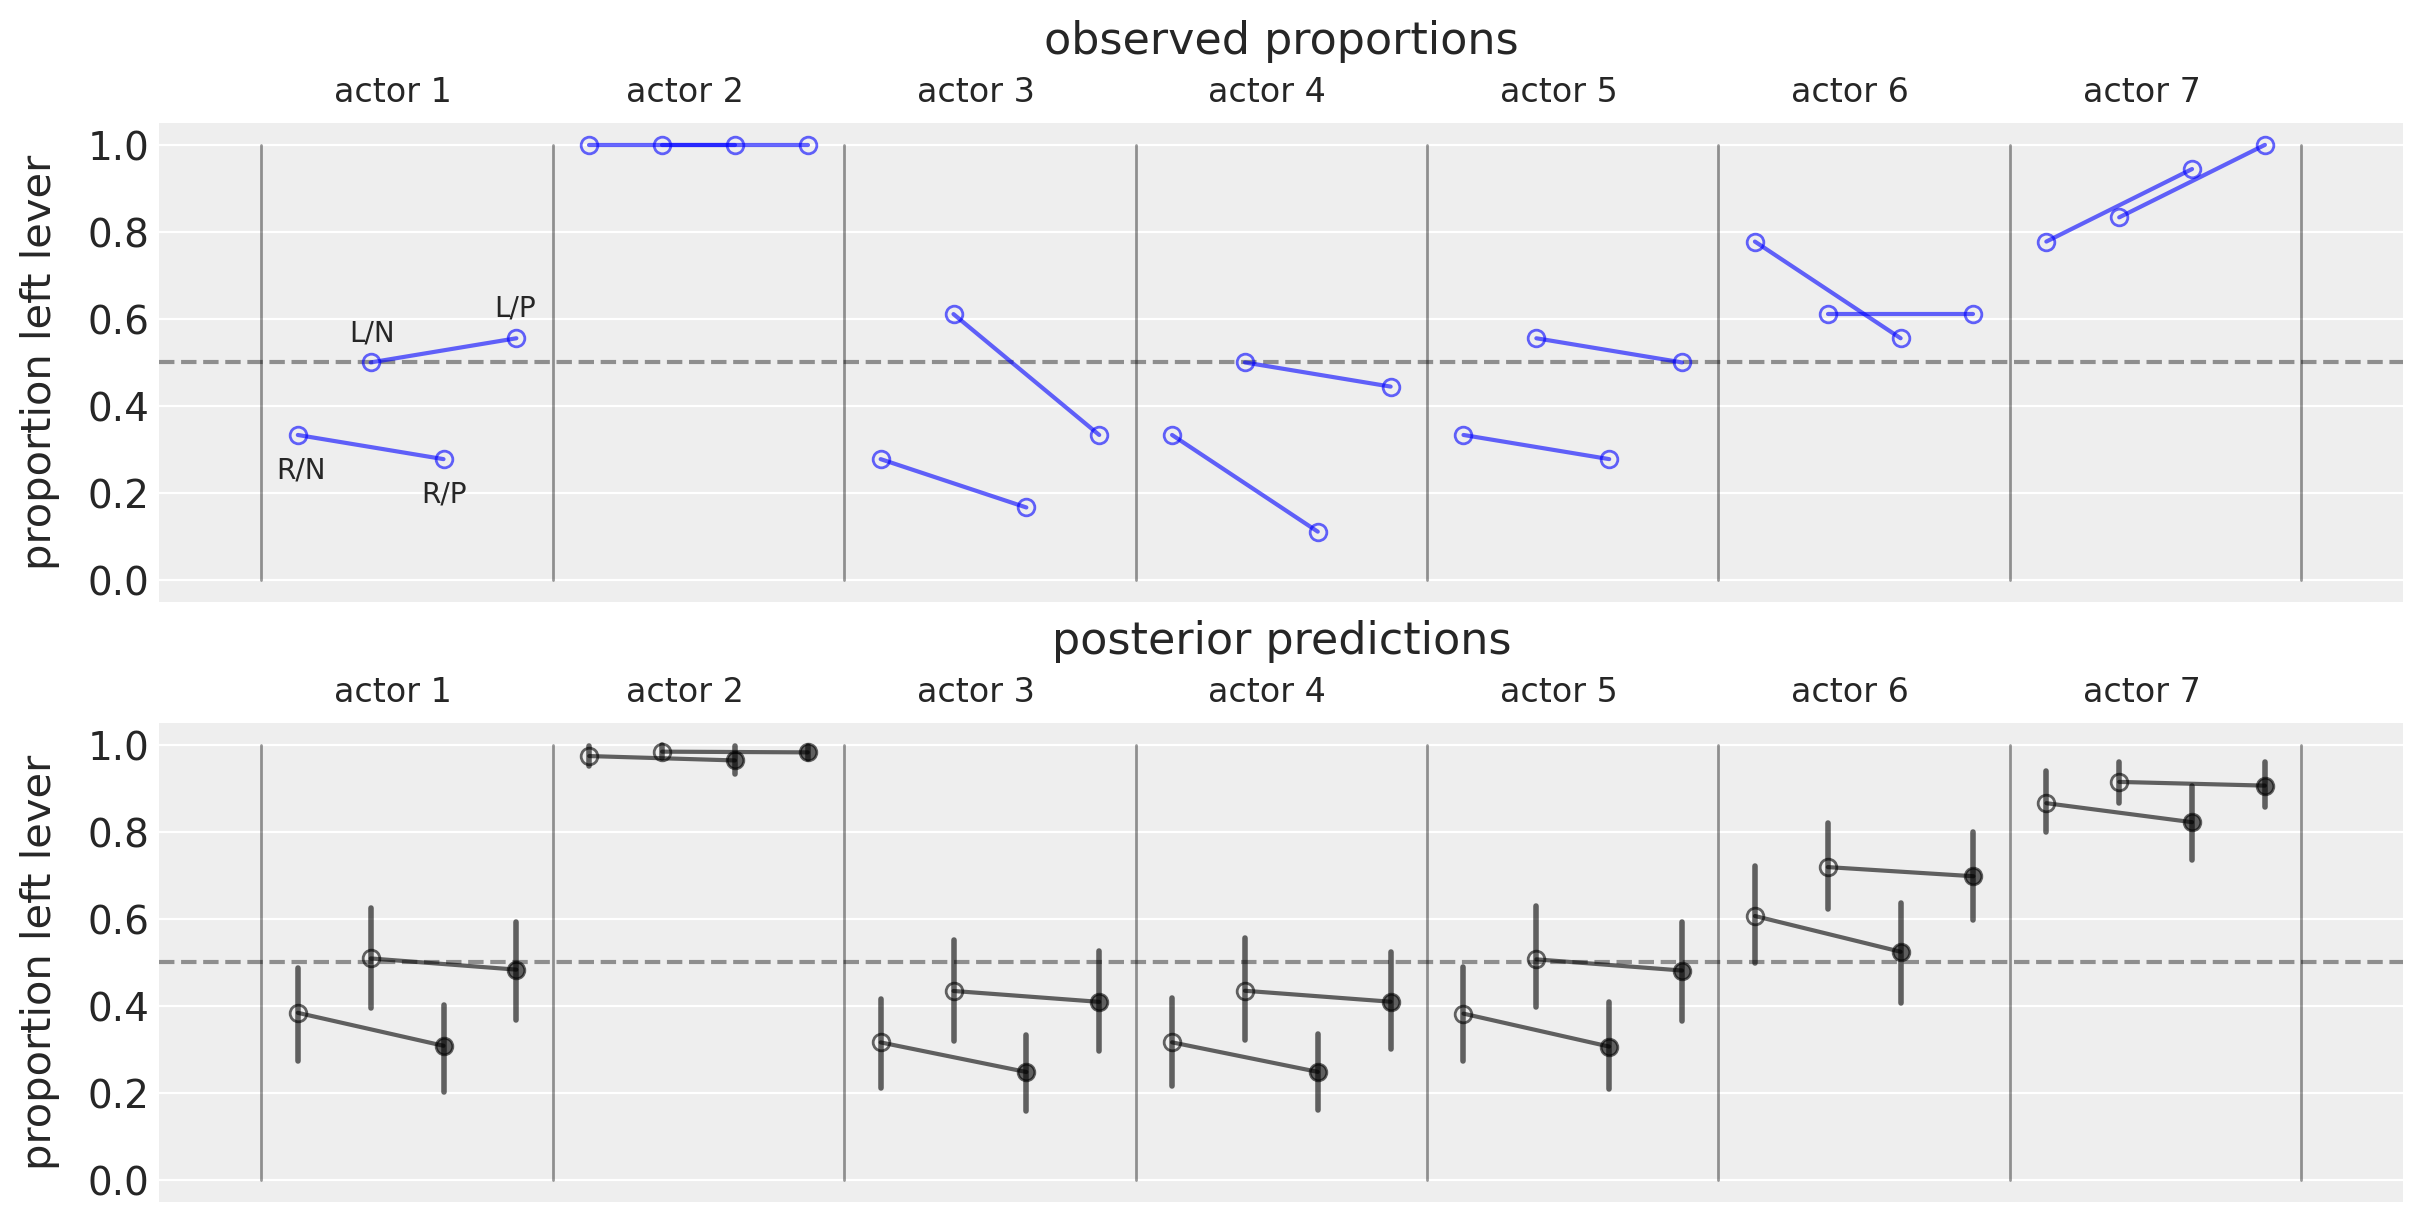

In [21]:
pl_val = pl.stack().values
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))
alpha, xoff, yoff = 0.6, 0.3, 0.05

ax0.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax0.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax0.plot(
        [actor * 4, actor * 4 + 2],
        [pl.loc[actor, 0], pl.loc[actor, 2]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [pl.loc[actor, 1], pl.loc[actor, 3]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4, actor * 4 + 1],
        [pl.loc[actor, 0], pl.loc[actor, 1]],
        "o",
        c="b",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [pl.loc[actor, 2], pl.loc[actor, 3]],
        "o",
        c="b",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax0.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax0.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
    if actor ==0:
        ax0.text(actor * 4 - xoff, pl.loc[actor, 0] - 2 * yoff, "R/N")
        ax0.text(actor * 4 + 1 - xoff, pl.loc[actor, 1] + yoff, "L/N")
        ax0.text(actor * 4 + 2 - xoff, pl.loc[actor, 2] - 2 * yoff, "R/P")
        ax0.text(actor * 4 + 3 - xoff, pl.loc[actor, 3] + yoff, "L/P")
ax0.set_xticks([])
ax0.set_ylabel("proportion left lever", labelpad=10)
ax0.set_title("observed proportions", pad=25)


ax1.plot([range(28), range(28)], az.hdi(ppd)["p"].T, "k-", lw=2, alpha=alpha)
ax1.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax1.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax1.plot(
        [actor * 4, actor * 4 + 2],
        [p_mu[actor, 0], p_mu[actor, 2]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [p_mu[actor, 1], p_mu[actor, 3]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4, actor * 4 + 1],
        [p_mu[actor, 0], p_mu[actor, 1]],
        "o",
        c="k",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [p_mu[actor, 2], p_mu[actor, 3]],
        "o",
        c="k",
        ms=6,
        alpha=alpha,
    )
    ax1.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax1.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
ax1.set_xticks([])
ax1.set_ylabel("proportion left lever", labelpad=10)
ax1.set_title("posterior predictions", pad=25)

In [25]:
side = d.prosoc_left.values #right 0, left 1
cond = d.condition.values # no partner 0, partner 1

あるはずのモデル11_5が消えている。  
更新される前のバージョン  
https://github.com/pymc-devs/pymc-resources/blob/061ce81c277ac93725beba5bd850a62cd5e81713/Rethinking_2/Chp_11.ipynb  
からCode 11.19を取り戻す。

In [26]:
with pm.Model() as m11_5:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    bs = pm.Normal("bs", 0.0, 0.5, shape=2)
    bc = pm.Normal("bc", 0.0, 0.5, shape=2)

    p = pm.math.invlogit(a[actor_idx] + bs[side] + bc[cond])

    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_11_5 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bs, bc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [27]:
with m11_4:
    pm.set_data({"actor_id": actor_idx, "treat_id": treat_idx})
    trace_11_4 = pm.sample(random_seed=RANDOM_SEED)

az.compare({"m11_4": trace_11_4, "m11_5": trace_11_5})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m11_5,0,-265.448195,7.816302,0.000000,1.0,9.555341,0.000000,False,log
m11_4,1,-266.150794,8.559208,0.702599,0.0,9.475534,0.658039,False,log


In [29]:
post_b_11_4 = az.extract_dataset(trace_11_4["posterior"])["b"]
np.exp(np.array(post_b_11_4[3,:]) - np.array(post_b_11_4[1, :])).mean().round(3)

0.937

In [31]:
d = pd.read_csv("chimpanzees.csv", sep=";")
d.actor = d.actor - 1
d["treatment"] = d.prosoc_left + 2 * d.condition

d_aggregated = (
    d.groupby(["treatment", "actor"]).sum().reset_index()[["treatment", "actor",
                                                           "pulled_left"]]
)
d_aggregated.head(10)

,treatment,actor,pulled_left
0,0,0,6
1,0,1,18
2,0,2,5
3,0,3,6
4,0,4,6
5,0,5,14
6,0,6,14
7,1,0,9
8,1,1,18
9,1,2,11


In [36]:
with pm.Model() as m11_6:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    b = pm.Normal("b", 0.0, 0.5, shape=len(treatments))

    p = pm.Deterministic(
           "p", pm.math.invlogit(a[d_aggregated.actor.values] +
                                 b[d_aggregated.treatment.values])
    )
    pulled_left = pm.Binomial("pulled_left", 18, p, observed=d_aggregated.pulled_left)
    trace_11_6 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [40]:
#az.compare({"m11_4": trace_11_4, "m11_6":trace_11_6})

In [44]:
# Calculate WAIC for both models
waic_m11_4 = az.waic(trace_11_4, pointwise=True)
waic_m11_6 = az.waic(trace_11_6, pointwise=True)

# Calculate PSIS for both models
loo_m11_4 = az.loo(trace_11_4, pointwise=True)
loo_m11_6 = az.loo(trace_11_6, pointwise=True)

# Extract WAIC and PSIS values
waic_values = [waic_m11_4.waic_i.sum().values, waic_m11_6.waic_i.sum().values]
psis_values = [loo_m11_4.pareto_k.sum().values, loo_m11_6.pareto_k.sum().values]

# Create a DataFrame for comparison
data = {'Model': ['m11_4', 'm11_6'], 'WAIC': waic_values, 'PSIS': psis_values}
comparison_df = pd.DataFrame(data)

# Print the final table
print(comparison_df)

C:\Users\satyk\AppData\Local\Temp\ipykernel_17544\3350061879.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  waic_m11_4 = az.waic(trace_11_4, pointwise=True)
C:\Users\satyk\AppData\Local\Temp\ipykernel_17544\3350061879.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  waic_m11_6 = az.waic(trace_11_6, pointwise=True)
C:\Users\satyk\anaconda3\envs\stat-rethink2-pymc_v4\lib\site-packages\arviz\stats\stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\satyk\AppData\Local\Temp\ipykernel_17544\3350061879.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  l

   Model                 WAIC                PSIS
0  m11_4  -266.12934948591334   22.10751052866499
1  m11_6   -56.37371530323411  12.254915192643116


C:\Users\satyk\AppData\Local\Temp\ipykernel_17544\3350061879.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo_m11_6 = az.loo(trace_11_6, pointwise=True)


In [45]:
# 集計された9のうち6の逸脱度
(-2 * stats.binom.logpmf(6, 9, 0.2)).round(5)

11.79048

In [46]:
# 集計されていない逸脱度
-2 * stats.bernoulli.logpmf([1, 1, 1, 1, 1, 1, 0, 0, 0], 0.2).sum().round(5)

20.65212